In [1]:
import scipy
import librosa
import numpy as np
import scipy.signal as signal
import os
import Dataset
from matplotlib import pyplot as plt
import random
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import MajMinCNN
device = torch.device('cpu')

/usr/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#hyper parameters
learning_rate = 0.001
batch_size = 5
num_epochs = 10

In [3]:
#load data
dataset = Dataset.Dataset_Load()
training_set = Dataset.Dataset_M(dataset.get_training())
testing_set = Dataset.Dataset_M(dataset.get_test())
dataloader_train = Dataset.DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
dataloader_test = Dataset.DataLoader(dataset=testing_set, batch_size=batch_size, shuffle=True)

2019


In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
            self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
            self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
            self.fc1 = nn.Linear(64*512*17,64)
            self.fc2 = nn.Linear(64,2)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = self.pool(x)

        x = x.reshape(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
#init model
model = CNN(2)

In [6]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
#training loop
for epoch in range(num_epochs):
    print(epoch)
    for batch_idx, (data,targets) in enumerate(dataloader_train):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #targets = targets.float()

        data = data.float()
        #targets = targets.unsqueeze(-1)
        scores = model(data)
        loss = criterion(scores, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
print('Done with training')

0
1
2
3
4
5
6
7
8
9
Done with training


In [11]:
def check_accuracy(model,loader):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x.float()
            scores = model(x)
            _, predictions = scores.max(1)
            
            #debugging stuff
            for i,j in zip(y, predictions):
                if i != j:
                    bad_class.append(x[i])
            #/end debugging stuff
            
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f'got {num_correct} / {num_samples}, with accuracy {float(num_correct/num_samples)}')

In [12]:
check_accuracy(model,dataloader_test)

got 930 / 993, with accuracy 0.9365558624267578


In [10]:
bad_class = []

In [ ]:
bad_class[0][0]

False


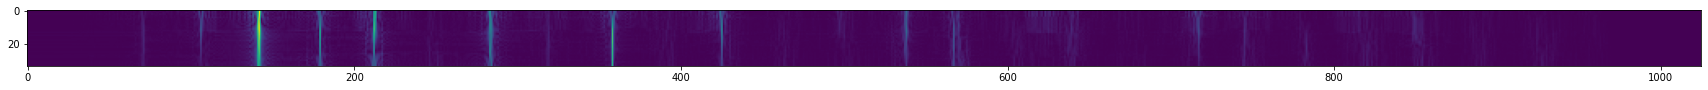

In [15]:
plt.figure(figsize=(30,20))
x = bad_class[27][0]
print(torch.equal(bad_class[24][0], bad_class[27][0]))
plt.imshow(x.t())